# Explorative Data Analysis

## 1. Preprocessing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from pathlib import Path
import os
from data_io import get_book
import sys
import math

Change the filenames here based on what you have downloaded

In [2]:
# metadata_filename = 'SPGC-metadata-2018-07-18.csv'
# counts_dirname = 'SPGC-counts-2018-07-18'
# tokens_dirname = 'SPGC-tokens-2018-07-18'

metadata_filename = 'metadata.csv'
counts_dirname = 'counts'
tokens_dirname = 'tokens'

metadata_df = pd.read_csv(metadata_filename).set_index('id')

metadata_df

title  \
id                                                            
PG0                                                     NaN   
PG1       The Declaration of Independence of the United ...   
PG2       The United States Bill of Rights: The Ten Orig...   
PG3                     John F. Kennedy's Inaugural Address   
PG4       Lincoln's Gettysburg Address: Given November 1...   
...                                                     ...   
PG57710                                  A Son of the State   
PG57711   Hudson Tercentenary: An historical retrospect ...   
PG57712                                      Proses moroses   
PG57713                         The Animal Parasites of Man   
PG999999                                      Piccole anime   

                                      author  authoryearofbirth  \
id                                                                
PG0                                      NaN                NaN   
PG1                        Jefferson, Thomas             1743.0   
PG2                            United States                NaN   
PG3       Kennedy, John F. (John Fitzgerald)             1917.0   
PG4                         Lincoln, Abraham             1809.0   
...                                      ...                ...   
PG57710        Ridge, W. Pett (William Pett)                NaN   
PG57711                   Chamberlain, Frank                NaN   
PG57712                    Gourmont, Remy de             1858.0   
PG57713                      Theobald, F. V.                NaN   
PG999999                                 NaN                NaN   

          authoryearofdeath language  downloads  \
id                                                
PG0                     NaN      NaN        NaN   
PG1                  1826.0   ['en']      604.0   
PG2                     NaN   ['en']      158.0   
PG3                  1963.0   ['en']       28.0   
PG4                  1865.0   ['en']       55.0   
...                     ...      ...        ...   
PG57710              1930.0   ['en']        0.0   
PG57711                 NaN   ['en']        0.0   
PG57712              1915.0   ['fr']        0.0   
PG57713                 NaN   ['en']        0.0   
PG999999                NaN      NaN        NaN   

                                                   subjects  type  
id                                                                 
PG0                                                   set()  Text  
PG1       {'United States -- History -- Revolution, 1775...  Text  
PG2       {'Civil rights -- United States -- Sources', '...  Text  
PG3       {'Presidents -- United States -- Inaugural add...  Text  
PG4       {'Consecration of cemeteries -- Pennsylvania -...  Text  
...                                                     ...   ...  
PG57710                                               set()  Text  
PG57711                                               set()  Text  
PG57712                                               set()  Text  
PG57713                                               set()  Text  
PG999999                                              set()  Text  

[57713 rows x 8 columns]

In [3]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57713 entries, PG0 to PG999999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              57642 non-null  object 
 1   author             55451 non-null  object 
 2   authoryearofbirth  42946 non-null  float64
 3   authoryearofdeath  41850 non-null  float64
 4   language           57711 non-null  object 
 5   downloads          57711 non-null  float64
 6   subjects           57713 non-null  object 
 7   type               57713 non-null  object 
dtypes: float64(3), object(5)
memory usage: 4.0+ MB


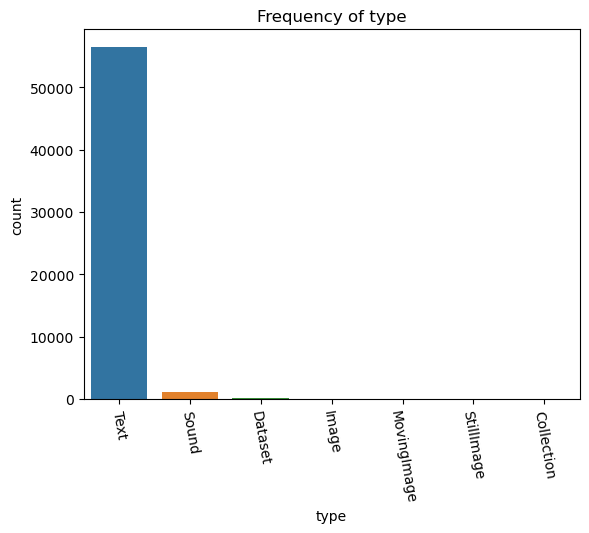

In [4]:
var = 'type'

sns.countplot(data=metadata_df, x=var, order=metadata_df[var].value_counts().index)
plt.title(f'Frequency of {var}')
plt.xticks(rotation=100000000)
plt.show()

In [5]:
metadata_df.type.unique()

array(['Text', 'Dataset', 'StillImage', 'MovingImage', 'Sound', 'Image',
       'Collection'], dtype=object)

We can see that there are other data types than 'Text', we only want 'Text'

We want to see how many documents are there in each language. First we filter out all languages with too few documents

In [6]:
s = metadata_df['language'].value_counts()
language_df = metadata_df[metadata_df.language.isin(s[s > 10].index)]

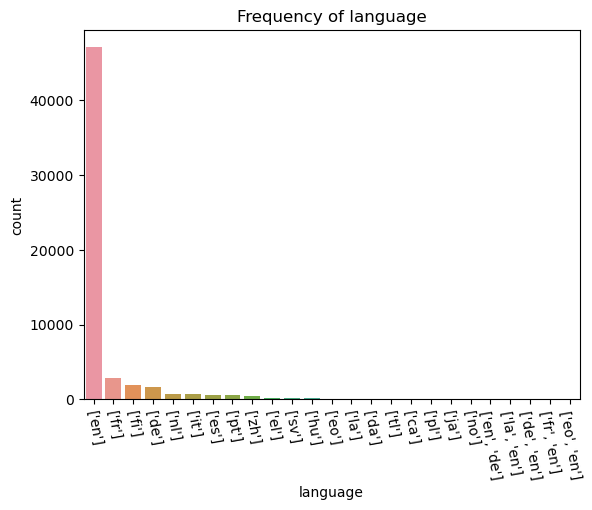

In [7]:
var = 'language'
sns.countplot(data=language_df, x=var, order=language_df[var].value_counts().index)
plt.title(f'Frequency of {var}')
plt.xticks(rotation=100000000)
plt.show()

We can see that there are a lot of different languages for the books. This project will only utilise the English documents. But it could be well adapted to a multi-lingual problems, or for a language other than English

In [8]:
metadata_df = metadata_df[(metadata_df.language == "['en']") & (metadata_df.type == 'Text')]

In [9]:
metadata_df[(metadata_df.author == 'Nietzsche, Friedrich Wilhelm') & (metadata_df.title == 'Thus Spake Zarathustra: A Book for All and None')]

title  \
id                                                        
PG1998  Thus Spake Zarathustra: A Book for All and None   

                              author  authoryearofbirth  authoryearofdeath  \
id                                                                           
PG1998  Nietzsche, Friedrich Wilhelm             1844.0             1900.0   

       language  downloads                                           subjects  \
id                                                                              
PG1998   ['en']     3742.0  {'Philosophy, German', 'Superman (Philosophica...   

        type  
id            
PG1998  Text

We also notice that this work by Nietzsche is originally in German, and it is a translated work. However, the name of the translator is not visible. This is a limitation for our data, that we have to take into consideration

Another limitation that can also be observed is that there are multiple works whose authors are numerous but only one of which is given authorship. For example, 'The Federalist Papers' has three authors as recorded by Gutenberg. However, only John Jay is given authorship. Another example is that 'The Communist Manifesto' has two authors: Karl Marx and Friedrich Engels, but only Engels' name is recorded. This is another limitation of the SGPC. https://www.gutenberg.org/ebooks/1404

In [10]:
metadata_df[metadata_df['title'].isin(['The Federalist Papers', 'The Communist Manifesto'])]

title             author  authoryearofbirth  \
id                                                                      
PG18      The Federalist Papers          Jay, John             1745.0   
PG61    The Communist Manifesto  Engels, Friedrich             1820.0   
PG1404    The Federalist Papers          Jay, John             1745.0   

        authoryearofdeath language  downloads  \
id                                              
PG18               1829.0   ['en']      461.0   
PG61               1895.0   ['en']     2608.0   
PG1404             1829.0   ['en']     2670.0   

                                                 subjects  type  
id                                                               
PG18    {'Constitutional history -- United States -- S...  Text  
PG61                           {'Socialism', 'Communism'}  Text  
PG1404  {'Constitutional history -- United States -- S...  Text

We now need to keep only the entries that have both the counts and the tokens file

In [11]:
file_not_exist = set()

for id_ in metadata_df.index:
    try:
        open(f'{counts_dirname}/{id_}_counts.txt')
        open(f'{tokens_dirname}/{id_}_tokens.txt')
    except FileNotFoundError:
        file_not_exist.add(id_)

print(f'Number of ids that do not have a corresponding counts or tokens file is: {len(file_not_exist)}')

Number of ids that do not have a corresponding counts or tokens file is: 458


Now we can drop all those entries

In [12]:
metadata_df = metadata_df[~metadata_df.index.isin(file_not_exist)]

We can now remove the columns (language, downloads, subjects, type) as they are not relevant to our modelling, and drop all rows that have a NULL values for any of the remaining columns 

In [13]:
SELECTED_COLUMNS = ['title', 'author', 'authoryearofbirth', 'authoryearofdeath']
metadata_df = metadata_df.dropna(subset=SELECTED_COLUMNS)
metadata_df = metadata_df[SELECTED_COLUMNS]
metadata_df['idx'] = range(0, len(metadata_df))

metadata_df

title  \
id                                                           
PG1      The Declaration of Independence of the United ...   
PG3                    John F. Kennedy's Inaugural Address   
PG4      Lincoln's Gettysburg Address: Given November 1...   
PG6                       Give Me Liberty or Give Me Death   
PG8             Abraham Lincoln's Second Inaugural Address   
...                                                    ...   
PG57523                       Confidential Chats with Boys   
PG57524  Index for Works of Mary Gaunt: Hyperlinks to a...   
PG57527  The great white way;: a record of an unusual v...   
PG57528            The Making of the Great West: 1512-1883   
PG57529         Lexington and Concord: A Camera Impression   

                                     author  authoryearofbirth  \
id                                                               
PG1                       Jefferson, Thomas             1743.0   
PG3      Kennedy, John F. (John Fitzgerald)             1917.0   
PG4                        Lincoln, Abraham             1809.0   
PG6                          Henry, Patrick             1736.0   
PG8                        Lincoln, Abraham             1809.0   
...                                     ...                ...   
PG57523                 Howard, William Lee             1860.0   
PG57524                         Gaunt, Mary             1861.0   
PG57527               Paine, Albert Bigelow             1861.0   
PG57528                 Drake, Samuel Adams             1833.0   
PG57529              Chamberlain, Samuel V.             1895.0   

         authoryearofdeath    idx  
id                                 
PG1                 1826.0      0  
PG3                 1963.0      1  
PG4                 1865.0      2  
PG6                 1799.0      3  
PG8                 1865.0      4  
...                    ...    ...  
PG57523             1918.0  31341  
PG57524             1942.0  31342  
PG57527             1937.0  31343  
PG57528             1905.0  31344  
PG57529             1975.0  31345  

[31346 rows x 5 columns]

Now we will put the counts, the total number of tokens, and all the tokens into a dictionary for lookup in further EDA analysis and training later on. We will also remove anything that cannot be parsed correctly

In [14]:
num_indices = len(metadata_df)

error_ids = {'int_idx': set(), 'str_idx': set()}
word_freq = {}
tokens_doc = {'id': metadata_df.index.to_numpy(dtype=object), 'num_tokens': np.zeros(num_indices, dtype=np.ushort), 'num_unique': np.zeros(num_indices, dtype=np.ushort), 'text': np.empty(num_indices, dtype=object)}

def get_counts_num_tokens(df):
    for int_idx , str_idx in enumerate(df.index):
        try:
            cur_counts = get_book(str_idx, os.path.join(counts_dirname), level='counts')

            if not cur_counts:
                raise Exception('cur_counts is empty')

            word_freq.update(cur_counts)

            tokens_doc['num_unique'][int_idx] = len(cur_counts.keys())
            tokens_doc['num_tokens'][int_idx] = np.sum(np.fromiter(cur_counts.values(), dtype=int))

            tokens_doc['text'][int_idx] = ' '.join(get_book(str_idx, os.path.join(tokens_dirname), level='tokens'))
            
        except Exception as e:
            print(f'Error at {str_idx}: ', e)
            error_ids['int_idx'].add(int_idx)
            error_ids['str_idx'].add(str_idx)

In [15]:
get_counts_num_tokens(metadata_df[0:10000])

Error at PG2357:  list index out of range
Error at PG5192:  list index out of range
Error at PG8700:  list index out of range


In [16]:
get_counts_num_tokens(metadata_df[10000:20000])

In [17]:
get_counts_num_tokens(metadata_df[20000:])

In [18]:
for k, v in tokens_doc.items():
    tokens_doc[k] = np.delete(v, list(error_ids['int_idx']), 0)
metadata_df = metadata_df[~metadata_df.index.isin(error_ids['str_idx'])]

tokens_df = pd.DataFrame.from_dict(tokens_doc).set_index('id')
metadata_df = pd.merge(metadata_df, tokens_df, left_index=True, right_index=True)

Now we try to get all of the duplicated books which have the same title and author, and remove the ones with less number of tokens

In [43]:
# https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
titles = metadata_df["title"]
titles_authors = metadata_df[["title", "author"]]
duplicated_entries = metadata_df[titles.isin(titles[titles_authors.duplicated()])].sort_values(["title", "num_tokens"])
duplicated_entries

title  \
id                                                           
PG2225   "Captains Courageous": A Story of the Grand Banks   
PG2186   "Captains Courageous": A Story of the Grand Banks   
PG43302  "The Kingdom of God Is Within You": Christiani...   
PG4602   "The Kingdom of God Is Within You": Christiani...   
PG25493                              A Cathedral Courtship   
...                                                    ...   
PG2034                Waverley; Or, 'Tis Sixty Years Since   
PG2782                                        Wilhelm Tell   
PG6788                                        Wilhelm Tell   
PG19154  With Lee in Virginia: A Story of the American ...   
PG2805   With Lee in Virginia: A Story of the American ...   

                               author  authoryearofbirth  authoryearofdeath  \
id                                                                            
PG2225               Kipling, Rudyard             1865.0             1936.0   
PG2186               Kipling, Rudyard             1865.0             1936.0   
PG43302            Tolstoy, Leo, graf             1828.0             1910.0   
PG4602             Tolstoy, Leo, graf             1828.0             1910.0   
PG25493    Wiggin, Kate Douglas Smith             1856.0             1923.0   
...                               ...                ...                ...   
PG2034                  Scott, Walter             1771.0             1832.0   
PG2782            Schiller, Friedrich             1759.0             1805.0   
PG6788            Schiller, Friedrich             1759.0             1805.0   
PG19154  Henty, G. A. (George Alfred)             1832.0             1902.0   
PG2805   Henty, G. A. (George Alfred)             1832.0             1902.0   

           idx  num_tokens  num_unique  \
id                                       
PG2225    1826       48548        4801   
PG2186    1817       62578        6705   
PG43302  24994           0           0   
PG4602    3853       15057        2873   
PG25493  15482           0           0   
...        ...         ...         ...   
PG2034    1689       16704        5487   
PG2782    2299       25282        8114   
PG6788    5593       50364       11058   
PG19154  12144           0           0   
PG2805    2319       56507       10250   

                                                      text  
id                                                          
PG2225   a man of honor by george cary eggleston illust...  
PG2186   http from page images generously made availabl...  
PG43302                                               None  
PG4602   transcriber notes every effort has been made t...  
PG25493                                               None  
...                                                    ...  
PG2034   online distributed proofreading team at http e...  
PG2782   scanned images of public domain material from ...  
PG6788   http from page images generously made availabl...  
PG19154                                               None  
PG2805   available by internet archive http note projec...  

[575 rows x 8 columns]

In [56]:
unique_highest_num_token = duplicated_entries[['title', 'author', 'num_tokens']].groupby(['title', 'author']).idxmax()
unique_highest_num_token

num_tokens
title                                              author                                 
"Captains Courageous": A Story of the Grand Banks  Kipling, Rudyard                 PG2186
"The Kingdom of God Is Within You": Christianit... Tolstoy, Leo, graf               PG4602
A Cathedral Courtship                              Wiggin, Kate Douglas Smith       PG1551
A Child's Garden of Verses                         Stevenson, Robert Louis           PG136
A Christmas Carol                                  Dickens, Charles                PG19337
...                                                                                    ...
Washington Irving                                  Boynton, Henry Walcott          PG25908
                                                   Warner, Charles Dudley           PG3101
Waverley; Or, 'Tis Sixty Years Since               Scott, Walter                    PG2034
Wilhelm Tell                                       Schiller, Friedrich              PG6788
With Lee in Virginia: A Story of the American C... Henty, G. A. (George Alfred)     PG2805

[263 rows x 1 columns]

In [63]:
non_unique_highest_num_token = duplicated_entries[~duplicated_entries.index.isin(unique_highest_num_token.num_tokens)]
non_unique_highest_num_token

title  \
id                                                           
PG2225   "Captains Courageous": A Story of the Grand Banks   
PG43302  "The Kingdom of God Is Within You": Christiani...   
PG25493                              A Cathedral Courtship   
PG19722                         A Child's Garden of Verses   
PG25608                         A Child's Garden of Verses   
...                                                    ...   
PG31811                        Wanderings in South America   
PG15984                                  Washington Irving   
PG5998                Waverley; Or, 'Tis Sixty Years Since   
PG2782                                        Wilhelm Tell   
PG19154  With Lee in Virginia: A Story of the American ...   

                               author  authoryearofbirth  authoryearofdeath  \
id                                                                            
PG2225               Kipling, Rudyard             1865.0             1936.0   
PG43302            Tolstoy, Leo, graf             1828.0             1910.0   
PG25493    Wiggin, Kate Douglas Smith             1856.0             1923.0   
PG19722       Stevenson, Robert Louis             1850.0             1894.0   
PG25608       Stevenson, Robert Louis             1850.0             1894.0   
...                               ...                ...                ...   
PG31811             Waterton, Charles             1782.0             1865.0   
PG15984        Warner, Charles Dudley             1829.0             1900.0   
PG5998                  Scott, Walter             1771.0             1832.0   
PG2782            Schiller, Friedrich             1759.0             1805.0   
PG19154  Henty, G. A. (George Alfred)             1832.0             1902.0   

           idx  num_tokens  num_unique  \
id                                       
PG2225    1826       48548        4801   
PG43302  24994           0           0   
PG25493  15482           0           0   
PG19722  12454           0           0   
PG25608  15547           0           0   
...        ...         ...         ...   
PG31811  18559           0           0   
PG15984  10540       31674        8847   
PG5998    5006        3996        9037   
PG2782    2299       25282        8114   
PG19154  12144           0           0   

                                                      text  
id                                                          
PG2225   a man of honor by george cary eggleston illust...  
PG43302                                               None  
PG25493                                               None  
PG19722                                               None  
PG25608                                               None  
...                                                    ...  
PG31811                                               None  
PG15984  free literature online soon in an extended ver...  
PG5998   transcriber note some presumed printer errors ...  
PG2782   scanned images of public domain material from ...  
PG19154                                               None  

[312 rows x 8 columns]

In [69]:
metadata_df = metadata_df[~metadata_df.index.isin(non_unique_highest_num_token.index)]

We confirm that we have selected the correct rows

In [70]:
metadata_df[metadata_df.title =='"Captains Courageous": A Story of the Grand Banks']

title            author  \
id                                                                            
PG2186  "Captains Courageous": A Story of the Grand Banks  Kipling, Rudyard   

        authoryearofbirth  authoryearofdeath   idx  num_tokens  num_unique  \
id                                                                           
PG2186             1865.0             1936.0  1817       62578        6705   

                                                     text  
id                                                         
PG2186  http from page images generously made availabl...

In [71]:
metadata_df

title  \
id                                                           
PG1      The Declaration of Independence of the United ...   
PG3                    John F. Kennedy's Inaugural Address   
PG4      Lincoln's Gettysburg Address: Given November 1...   
PG6                       Give Me Liberty or Give Me Death   
PG8             Abraham Lincoln's Second Inaugural Address   
...                                                    ...   
PG57523                       Confidential Chats with Boys   
PG57524  Index for Works of Mary Gaunt: Hyperlinks to a...   
PG57527  The great white way;: a record of an unusual v...   
PG57528            The Making of the Great West: 1512-1883   
PG57529         Lexington and Concord: A Camera Impression   

                                     author  authoryearofbirth  \
id                                                               
PG1                       Jefferson, Thomas             1743.0   
PG3      Kennedy, John F. (John Fitzgerald)             1917.0   
PG4                        Lincoln, Abraham             1809.0   
PG6                          Henry, Patrick             1736.0   
PG8                        Lincoln, Abraham             1809.0   
...                                     ...                ...   
PG57523                 Howard, William Lee             1860.0   
PG57524                         Gaunt, Mary             1861.0   
PG57527               Paine, Albert Bigelow             1861.0   
PG57528                 Drake, Samuel Adams             1833.0   
PG57529              Chamberlain, Samuel V.             1895.0   

         authoryearofdeath    idx  num_tokens  num_unique  \
id                                                          
PG1                 1826.0      0       24161        2905   
PG3                 1963.0      1       24853        3912   
PG4                 1865.0      2       19959        2881   
PG6                 1799.0      3       24982        2872   
PG8                 1865.0      4       51684       12748   
...                    ...    ...         ...         ...   
PG57523             1918.0  31341           0           0   
PG57524             1942.0  31342           0           0   
PG57527             1937.0  31343           0           0   
PG57528             1905.0  31344           0           0   
PG57529             1975.0  31345           0           0   

                                                      text  
id                                                          
PG1      transcriber note page scan source http honor a...  
PG3      transcriber notes page source http dq this vol...  
PG4      transcriber notes page scan source http the di...  
PG6      transcriber note page scan source http dq book...  
PG8      transcriber notes page scan source http the di...  
...                                                    ...  
PG57523                                               None  
PG57524                                               None  
PG57527                                               None  
PG57528                                               None  
PG57529                                               None  

[31031 rows x 8 columns]

This is the entry with the PGID which has the highest number of tokens

**Export preprocessed dataframe**

In [72]:
metadata_df.to_csv('preprocessed.csv')

## 2. Data Analysis

### a. Text

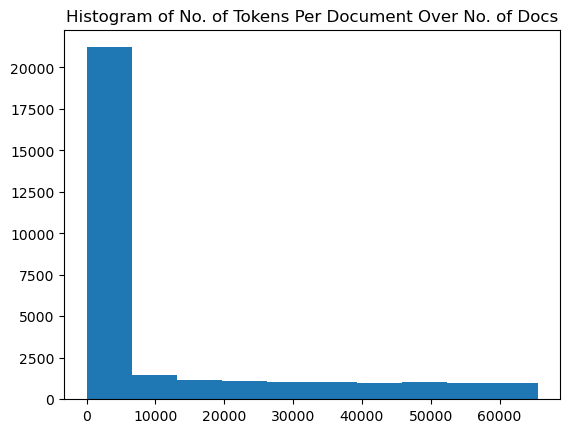

In [98]:
plt.hist(metadata_df.num_tokens, bins=10)
plt.title('Histogram of No. of Tokens Per Document Over No. of Docs')
plt.show()

We can see that most documents have the number of tokens around 10^5, or otherwise 10^4

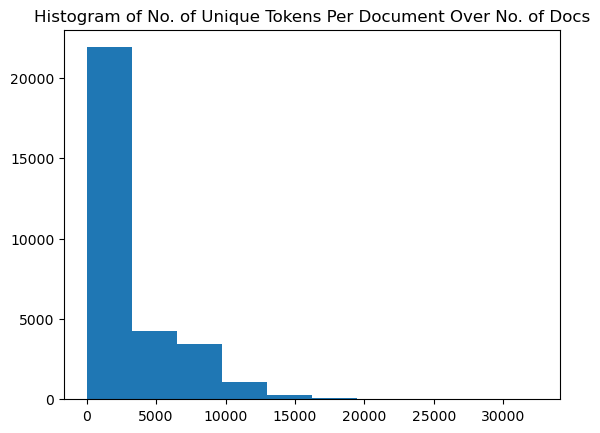

In [101]:
plt.hist(metadata_df.num_unique, bins=10)
plt.title('Histogram of No. of Unique Tokens Per Document Over No. of Docs')
plt.show()

We can see that most documents have the number of unique tokens a little bit less than 10^4

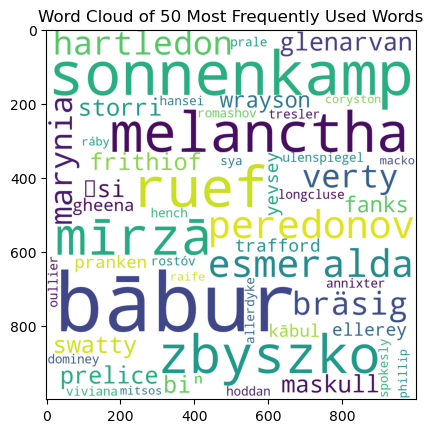

In [102]:
# https://stackoverflow.com/questions/43145199/create-wordcloud-from-dictionary-values
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(word_freq)
plt.title('Word Cloud of 50 Most Frequently Used Words')
plt.imshow(wc)

### b. Author

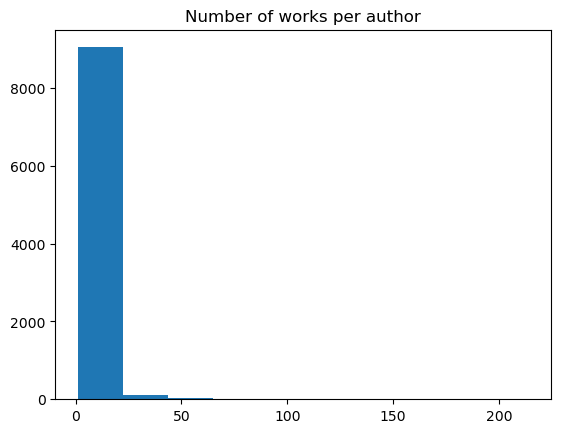

In [120]:
plt.hist(metadata_df['author'].value_counts(), bins=10)
plt.title('Number of works per author')
plt.show()

In [121]:
metadata_df[['authoryearofbirth', 'authoryearofdeath']].describe()

authoryearofbirth  authoryearofdeath
count       31031.000000       31031.000000
mean         1822.548226        1892.970610
std           177.131728         178.230488
min          -750.000000        -650.000000
25%          1822.000000        1893.000000
50%          1850.000000        1918.000000
75%          1866.000000        1940.000000
max          1970.000000        2015.000000

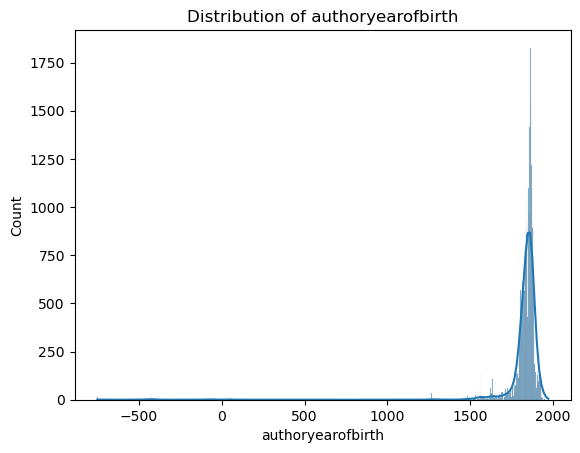

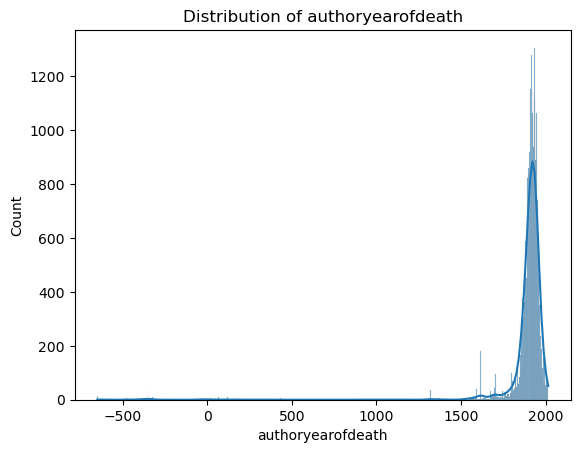

In [122]:
continuous_vars = ['authoryearofbirth', 'authoryearofdeath']
for var in continuous_vars:
    sns.histplot(data=metadata_df, x=var, kde=True)
    plt.title(f'Distribution of {var}')
    plt.show()

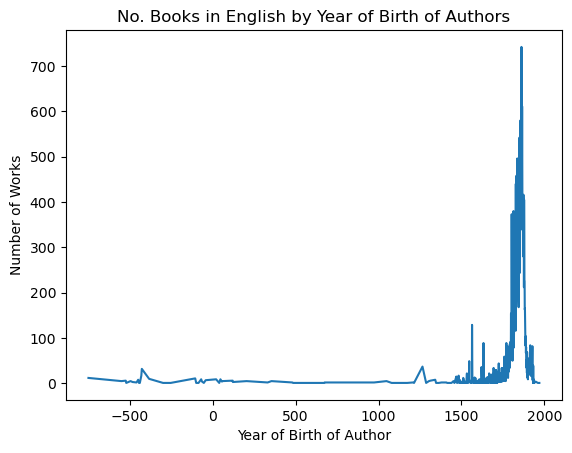

In [123]:
sns.lineplot(x = metadata_df['authoryearofbirth'].value_counts().index, y=metadata_df['authoryearofbirth'].value_counts())
plt.title('No. Books in English by Year of Birth of Authors')
plt.xlabel('Year of Birth of Author')
plt.ylabel('Number of Works')

plt.show()

We can see that most English books in the dataset are written by people born around the 1800

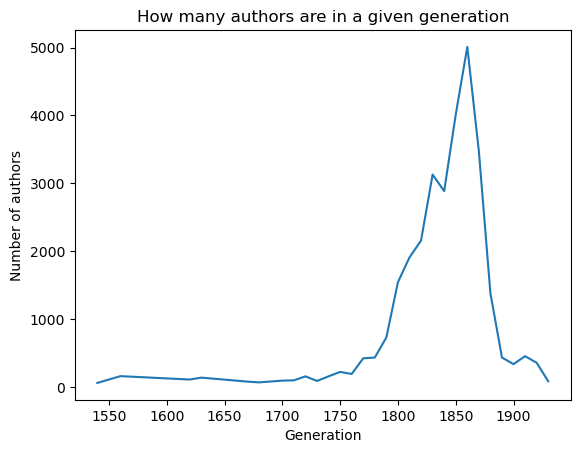

In [124]:
ana_year_df = metadata_df[['author', 'authoryearofbirth']]
ana_year_df.insert(2, 'generation', ana_year_df['authoryearofbirth'].apply(lambda x: math.floor(x * 0.1)*10), True)

counts = ana_year_df.groupby('generation')['author'].count().sort_values(ascending=False).head(30)
sns.lineplot(x = counts.index, y=counts)
plt.title('How many authors are in a given generation')
plt.xlabel('Generation')
plt.ylabel('Number of authors')
plt.show()

By extension, the generation with the most amount of authors are in the late 1800s